<a href="https://colab.research.google.com/github/NguyenLoi851/MultiLableClassification/blob/main/Naive_Bayes_with_LabelPowerset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import library

In [ ]:
pip install scikit-multilearn

In [ ]:
# import and read csv
import pandas as pd
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from ast import literal_eval
import numpy as np
import string
import re
import pandas as pd


#Pre-processing data
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

# Visualization data
import matplotlib.pyplot as plt 
import seaborn as sns
import itertools

#Binarizer labels
from sklearn.preprocessing import MultiLabelBinarizer

#Split and vectorizer data
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Train the model
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

#Model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

#Oversampling
from imblearn.over_sampling import RandomOverSampler

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Read and filter data

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
  
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


link = 'https://drive.google.com/file/d/1_Qzhh4ycfWVSu_Umza8vuu92hQQXHkHC/view?usp=sharing'
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('arxiv.csv')  
  
arxiv_data = pd.read_csv('arxiv.csv')
arxiv_data.head()

,titles,summaries,terms
0,Revealing the Field Sub-subgiant Population Us...,Sub-subgiant stars (SSGs) fall below the subgi...,"['astro-ph.SR', 'astro-ph.GA']"
1,ALMA detection of ethyl cyanide and methyl for...,"In millimeter/submillimeter wavelength, the st...",['astro-ph.GA']
2,Accretion processes in the galaxy cluster Hydr...,"Clusters of galaxies evolve and accrete mass, ...","['astro-ph.CO', 'astro-ph.GA']"
3,Radio astronomy locates the neutrino origin in...,High-energy astrophysical neutrinos have been ...,"['astro-ph.HE', 'astro-ph.GA']"
4,The extragalactic $γ$-ray background: imprints...,Star-forming galaxies (SFGs) are expected to h...,"['astro-ph.GA', 'astro-ph.HE']"


In [ ]:
arxiv_data_filtered = arxiv_data

In [ ]:
# Transform raw string of labels into a list of string
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)

In [ ]:
arxiv_data_filtered["terms"].values[0]

['astro-ph.SR', 'astro-ph.GA']

In [ ]:
arxiv_data_filtered.head()

,titles,summaries,terms
0,Revealing the Field Sub-subgiant Population Us...,Sub-subgiant stars (SSGs) fall below the subgi...,"[astro-ph.SR, astro-ph.GA]"
1,ALMA detection of ethyl cyanide and methyl for...,"In millimeter/submillimeter wavelength, the st...",[astro-ph.GA]
2,Accretion processes in the galaxy cluster Hydr...,"Clusters of galaxies evolve and accrete mass, ...","[astro-ph.CO, astro-ph.GA]"
3,Radio astronomy locates the neutrino origin in...,High-energy astrophysical neutrinos have been ...,"[astro-ph.HE, astro-ph.GA]"
4,The extragalactic $γ$-ray background: imprints...,Star-forming galaxies (SFGs) are expected to h...,"[astro-ph.GA, astro-ph.HE]"


In [ ]:
arxiv_data_filtered.describe()

,titles,summaries,terms
count,43539,43539,43539
unique,33062,33077,130
top,VLBI20-30: a scientific roadmap for the next d...,This white paper describes the science case fo...,[astro-ph.GA]
freq,6,6,4639


In [ ]:
duplicated_titles = arxiv_data_filtered["titles"].duplicated().sum()
print("Số dữ liệu trùng lặp:", duplicated_titles)

Số dữ liệu trùng lặp: 10477


In [ ]:
arxiv_data_filtered = arxiv_data_filtered[~arxiv_data_filtered["titles"].duplicated()]
data_after_filtered = len(arxiv_data_filtered)
print("Số dữ liệu sau khi lọc:", data_after_filtered)

Số dữ liệu sau khi lọc: 33062


#Pre-processing data

In [ ]:
def clean_text(text):
  # remove new line characters
  text = re.sub(r"\n", " ", text)
  # remove email
  text = re.sub(r"([A-Za-z0-9_.+-]+@[A-Za-z0-9-]+\.?[A-Za-z0-9-.]+)", "", text)
  # remove url
  text = re.sub(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*", "", text)
  # remove punctuation
  text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
  # remove words including numbers
  text = re.sub(r"\w*\d\w*", "", text)
  # replace multiple whitespace by one whitespace
  text = re.sub(r"\s+", " ", text)
  # lower all text
  text = text.lower()
  # strip all text
  text = text.strip()
  return text

In [ ]:
def remove_stopwords(text):
  stop_words = stopwords.words('english')
  cleaned_text = []
  # turn text to a list of words
  word_list = text.split()
  for word in word_list:
    if word not in stop_words:
      cleaned_text.append(word)
  return ' '.join(cleaned_text)

In [ ]:
def lemmatize_text(text):
  wnl = WordNetLemmatizer()
  pos_text = pos_tag(word_tokenize(text))
  cleaned_text = []
  for word, tag in pos_text:
    wntag = tag[0].lower()
    wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
    if not wntag:
      lem_word = word
    else:
      lem_word = wnl.lemmatize(word, wntag)
    cleaned_text.append(lem_word)
  return ' '.join(cleaned_text)

In [ ]:
arxiv_data_filtered['summaries'] = arxiv_data_filtered['summaries'].apply(clean_text)
arxiv_data_filtered['summaries'] = arxiv_data_filtered['summaries'].apply(remove_stopwords)
arxiv_data_filtered['summaries'] = arxiv_data_filtered['summaries'].apply(lemmatize_text)
arxiv_data_filtered['summaries']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

0        sub subgiant star ssgs fall subgiant branch re...
1        millimeter submillimeter wavelength study comp...
2        cluster galaxy evolve accrete mass mostly smal...
3        high energy astrophysical neutrino observe sev...
4        star form galaxy sfgs expect harbour abundant ...
                               ...                        
43532    investigate formation process galactic globula...
43535    non local thermodynamic equilibrium nlte level...
43536    recent study flare loop oscillation event dece...
43537    perform comprehensive study stellar population...
43538    study basic property three possible r process ...
Name: summaries, Length: 33062, dtype: object

In [ ]:
arxiv_data_filtered["summaries"][3]

'high energy astrophysical neutrino observe several telescope last decade source still remain unknown address problem locate astrophysical neutrino source statistical manner show blazars positionally associate icecube neutrino detection stronger parsec scale radio core rest sample probability chance coincidence correspond significance sigma explicitly list four strong radio blazars highly probable source neutrinos tev nrao pks pks least radio bright blazars emit neutrino lower energy start tevs use continuous ratan monitoring vlbi select blazars find radio flare frequency ghz coincide neutrino arrival date pronounce example behavior pks experience major flare demonstrate majority icecube astrophysical neutrino flux derive muon track analysis may explain blazars agns bright doppler boost jet high energy neutrino produce photohadronic interaction within parsec scale relativistic jet radio bright blazars associate neutrino detection diverse gamma ray property suggest gamma ray neutrino ma

#Visualization data

In [ ]:
all_terms = sum(arxiv_data_filtered["terms"],[])
all_terms = nltk.FreqDist(all_terms) 
# # create dataframe
all_terms_df = pd.DataFrame({'Term': list(all_terms.keys()), 
                              'Count': list(all_terms.values())})

In [ ]:
print(all_terms_df.sort_values(by = ['Count']))

          Term  Count
2  astro-ph.CO   4842
4  astro-ph.IM   6782
3  astro-ph.HE   6888
5  astro-ph.EP   8464
0  astro-ph.SR   9443
1  astro-ph.GA  10854


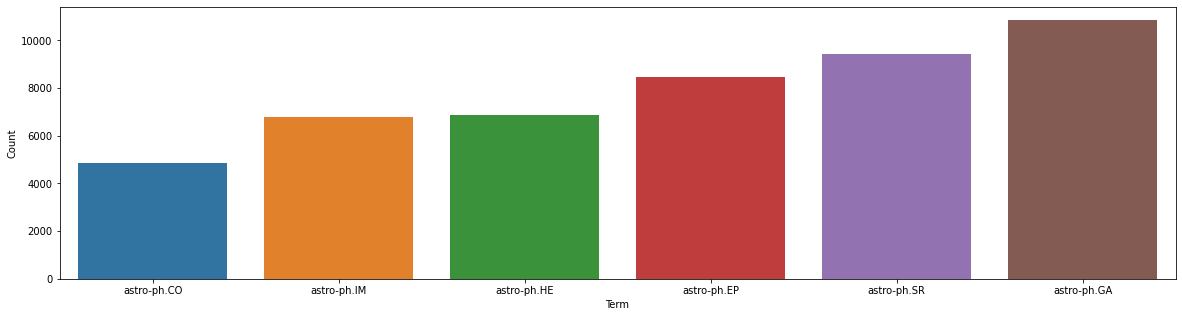

In [ ]:
g = all_terms_df.sort_values(by = ['Count'])
plt.figure(figsize=(20,5)) 
ax = sns.barplot(data=g, y= "Count", x = "Term") 
plt.show()

In [ ]:
print((arxiv_data_filtered["terms"].value_counts()[1:20]))

[astro-ph.EP]                 4571
[astro-ph.HE]                 3559
[astro-ph.SR]                 3062
[astro-ph.IM]                 2832
[astro-ph.CO]                 2258
[astro-ph.EP, astro-ph.SR]    1241
[astro-ph.SR, astro-ph.GA]    1026
[astro-ph.GA, astro-ph.CO]     913
[astro-ph.GA, astro-ph.SR]     752
[astro-ph.SR, astro-ph.EP]     680
[astro-ph.HE, astro-ph.GA]     554
[astro-ph.CO, astro-ph.GA]     541
[astro-ph.EP, astro-ph.IM]     492
[astro-ph.HE, astro-ph.SR]     448
[astro-ph.GA, astro-ph.HE]     417
[astro-ph.IM, astro-ph.HE]     405
[astro-ph.IM, astro-ph.EP]     358
[astro-ph.SR, astro-ph.HE]     357
[astro-ph.HE, astro-ph.IM]     331
Name: terms, dtype: int64


In [ ]:
# arxiv_data_filtered.to_csv('arxiv_data.csv', index = False)
# from google.colab import files
# files.download('arxiv_data.csv')

#LabelPowerset

#Without oversampling




##Train the model
*Vectorizer by TFIDF*

###Split and vectorizer by Tfidf

In [ ]:

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(arxiv_data_filtered.terms)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    arxiv_data_filtered['summaries'],
    labels,
    test_size = 0.2,
    )

In [ ]:
vocab = list(mlb.classes_)

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
vectorizer.fit(X_test)
X_train_vector = vectorizer.transform(X_train)
X_test_vector = vectorizer.transform(X_test)

In [ ]:
print(X_train_vector.shape)
print(X_test_vector.shape)

(26449, 19076)
(6613, 19076)


###Train the model with MultinomialNB and evaluate

In [ ]:
# initialize Label Powerset multi-label classifier
# with a multinomial naive bayes base classifier
model = LabelPowerset(MultinomialNB())

model.fit(X_train_vector, y_train)

LabelPowerset(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
y_pred_prob = model.predict_proba(X_test_vector)
y_pred_prob = y_pred_prob.toarray()

In [ ]:
def get_y_pred(y_pred_prob, k=3, threshold=0.5):
    y_pred = []
    for pred in y_pred_prob:
        top_k_labels = [
            x
            for _,x in sorted(
                zip(pred, vocab),
                key=lambda pair: pair[0],
                reverse=True,
            )
        ][:k]
        y_top_k_labels = np.zeros(y_pred_prob[0].shape[0])
        for j in range(len(vocab)):
            if(vocab[j] in top_k_labels):
                if(pred[j] > threshold):
                    y_top_k_labels[j] = 1
                else:
                    top_k_labels.remove(vocab[j])
        y_pred.append(y_top_k_labels)
    y_pred = np.array(y_pred)   
    return y_pred


In [ ]:
for k in range(1,7):
    for threshold in np.arange(0.1,0.9,0.1):
        y_pred = get_y_pred(y_pred_prob, k, threshold)
        from sklearn.metrics import accuracy_score
        acc = accuracy_score(y_test, y_pred)
        print(f"Exact Match Radio accuracy on the test set: {round(acc * 100, 2)}% - with k = {k} and threshold = {threshold}")

Exact Match Radio accuracy on the test set: 56.69% - with k = 1 and threshold = 0.1
Exact Match Radio accuracy on the test set: 56.69% - with k = 1 and threshold = 0.2
Exact Match Radio accuracy on the test set: 56.59% - with k = 1 and threshold = 0.30000000000000004
Exact Match Radio accuracy on the test set: 55.95% - with k = 1 and threshold = 0.4
Exact Match Radio accuracy on the test set: 54.0% - with k = 1 and threshold = 0.5
Exact Match Radio accuracy on the test set: 50.76% - with k = 1 and threshold = 0.6
Exact Match Radio accuracy on the test set: 46.76% - with k = 1 and threshold = 0.7000000000000001
Exact Match Radio accuracy on the test set: 40.89% - with k = 1 and threshold = 0.8
Exact Match Radio accuracy on the test set: 49.51% - with k = 2 and threshold = 0.1
Exact Match Radio accuracy on the test set: 56.6% - with k = 2 and threshold = 0.2
Exact Match Radio accuracy on the test set: 58.46% - with k = 2 and threshold = 0.30000000000000004
Exact Match Radio accuracy on t

In [ ]:
y_pred = get_y_pred(y_pred_prob, k=2, threshold=0.5)
from sklearn.metrics import multilabel_confusion_matrix
m = multilabel_confusion_matrix(y_test, y_pred)

for i in range(0,len(m)):
    print("multilabel_confusion_matrix_of: "+vocab[i])
    print(m[i])
    print()

multilabel_confusion_matrix_of: astro-ph.CO
[[5656    8]
 [ 555  394]]

multilabel_confusion_matrix_of: astro-ph.EP
[[4878   64]
 [ 259 1412]]

multilabel_confusion_matrix_of: astro-ph.GA
[[4236  197]
 [ 534 1646]]

multilabel_confusion_matrix_of: astro-ph.HE
[[5154   49]
 [ 474  936]]

multilabel_confusion_matrix_of: astro-ph.IM
[[5213   18]
 [ 711  671]]

multilabel_confusion_matrix_of: astro-ph.SR
[[4728    7]
 [1273  605]]



In [ ]:
print(classification_report(y_test, y_pred,target_names=vocab))

              precision    recall  f1-score   support

 astro-ph.CO       0.98      0.42      0.58       949
 astro-ph.EP       0.96      0.85      0.90      1671
 astro-ph.GA       0.89      0.76      0.82      2180
 astro-ph.HE       0.95      0.66      0.78      1410
 astro-ph.IM       0.97      0.49      0.65      1382
 astro-ph.SR       0.99      0.32      0.49      1878

   micro avg       0.94      0.60      0.73      9470
   macro avg       0.96      0.58      0.70      9470
weighted avg       0.95      0.60      0.71      9470
 samples avg       0.85      0.69      0.74      9470



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Train the model with BernoulliNB and evaluate

In [ ]:
# initialize Label Powerset multi-label classifier
# with a bernoulli naive bayes base classifier
model = LabelPowerset(BernoulliNB())

model.fit(X_train_vector, y_train)

LabelPowerset(classifier=BernoulliNB(), require_dense=[True, True])

In [ ]:
y_pred_prob = model.predict_proba(X_test_vector)
y_pred_prob = y_pred_prob.toarray()

In [ ]:
for k in range(1,7):
    for threshold in np.arange(0.1,0.9,0.1):
        y_pred = get_y_pred(y_pred_prob, k, threshold)
        from sklearn.metrics import accuracy_score
        acc = accuracy_score(y_test, y_pred)
        print(f"Exact Match Radio accuracy on the test set: {round(acc * 100, 2)}% - with k = {k} and threshold = {threshold}")

Exact Match Radio accuracy on the test set: 57.89% - with k = 1 and threshold = 0.1
Exact Match Radio accuracy on the test set: 57.89% - with k = 1 and threshold = 0.2
Exact Match Radio accuracy on the test set: 57.89% - with k = 1 and threshold = 0.30000000000000004
Exact Match Radio accuracy on the test set: 57.89% - with k = 1 and threshold = 0.4
Exact Match Radio accuracy on the test set: 57.87% - with k = 1 and threshold = 0.5
Exact Match Radio accuracy on the test set: 57.8% - with k = 1 and threshold = 0.6
Exact Match Radio accuracy on the test set: 57.6% - with k = 1 and threshold = 0.7000000000000001
Exact Match Radio accuracy on the test set: 57.42% - with k = 1 and threshold = 0.8
Exact Match Radio accuracy on the test set: 60.28% - with k = 2 and threshold = 0.1
Exact Match Radio accuracy on the test set: 60.4% - with k = 2 and threshold = 0.2
Exact Match Radio accuracy on the test set: 60.61% - with k = 2 and threshold = 0.30000000000000004
Exact Match Radio accuracy on th

In [ ]:
y_pred = get_y_pred(y_pred_prob, k=2, threshold=0.5)
from sklearn.metrics import multilabel_confusion_matrix
m = multilabel_confusion_matrix(y_test, y_pred)

for i in range(0,len(m)):
    print("multilabel_confusion_matrix_of: "+vocab[i])
    print(m[i])
    print()

multilabel_confusion_matrix_of: astro-ph.CO
[[5542  122]
 [ 318  631]]

multilabel_confusion_matrix_of: astro-ph.EP
[[4839  103]
 [ 214 1457]]

multilabel_confusion_matrix_of: astro-ph.GA
[[4217  216]
 [ 566 1614]]

multilabel_confusion_matrix_of: astro-ph.HE
[[5050  153]
 [ 295 1115]]

multilabel_confusion_matrix_of: astro-ph.IM
[[5081  150]
 [ 410  972]]

multilabel_confusion_matrix_of: astro-ph.SR
[[4418  317]
 [ 522 1356]]



In [ ]:
print(classification_report(y_test, y_pred,target_names=vocab))

              precision    recall  f1-score   support

 astro-ph.CO       0.84      0.66      0.74       949
 astro-ph.EP       0.93      0.87      0.90      1671
 astro-ph.GA       0.88      0.74      0.80      2180
 astro-ph.HE       0.88      0.79      0.83      1410
 astro-ph.IM       0.87      0.70      0.78      1382
 astro-ph.SR       0.81      0.72      0.76      1878

   micro avg       0.87      0.75      0.81      9470
   macro avg       0.87      0.75      0.80      9470
weighted avg       0.87      0.75      0.81      9470
 samples avg       0.90      0.82      0.83      9470



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Train the model
*Vectorizer by CountVectorizer*

###Vectorizer by CountVectorizer

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
vectorizer.fit(X_test)
X_train_vector = vectorizer.transform(X_train)
X_test_vector = vectorizer.transform(X_test)

###Train the model with MultinomialNB and evaluate


In [ ]:
# initialize Label Powerset multi-label classifier
# with a multinomial naive bayes base classifier
model = LabelPowerset(MultinomialNB())

model.fit(X_train_vector, y_train)

LabelPowerset(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
y_pred_prob = model.predict_proba(X_test_vector)
y_pred_prob = y_pred_prob.toarray()

In [ ]:
for k in range(1,7):
    for threshold in np.arange(0.1,0.9,0.1):
        y_pred = get_y_pred(y_pred_prob, k, threshold)
        from sklearn.metrics import accuracy_score
        acc = accuracy_score(y_test, y_pred)
        print(f"Exact Match Radio accuracy on the test set: {round(acc * 100, 2)}% - with k = {k} and threshold = {threshold}")

Exact Match Radio accuracy on the test set: 58.49% - with k = 1 and threshold = 0.1
Exact Match Radio accuracy on the test set: 58.49% - with k = 1 and threshold = 0.2
Exact Match Radio accuracy on the test set: 58.49% - with k = 1 and threshold = 0.30000000000000004
Exact Match Radio accuracy on the test set: 58.49% - with k = 1 and threshold = 0.4
Exact Match Radio accuracy on the test set: 58.48% - with k = 1 and threshold = 0.5
Exact Match Radio accuracy on the test set: 58.43% - with k = 1 and threshold = 0.6
Exact Match Radio accuracy on the test set: 58.42% - with k = 1 and threshold = 0.7000000000000001
Exact Match Radio accuracy on the test set: 58.35% - with k = 1 and threshold = 0.8
Exact Match Radio accuracy on the test set: 58.88% - with k = 2 and threshold = 0.1
Exact Match Radio accuracy on the test set: 59.67% - with k = 2 and threshold = 0.2
Exact Match Radio accuracy on the test set: 59.99% - with k = 2 and threshold = 0.30000000000000004
Exact Match Radio accuracy on

In [ ]:
y_pred = get_y_pred(y_pred_prob, k=2, threshold=0.5)
from sklearn.metrics import multilabel_confusion_matrix
m = multilabel_confusion_matrix(y_test, y_pred)

for i in range(0,len(m)):
    print("multilabel_confusion_matrix_of: "+vocab[i])
    print(m[i])
    print()

multilabel_confusion_matrix_of: astro-ph.CO
[[5489  175]
 [ 260  689]]

multilabel_confusion_matrix_of: astro-ph.EP
[[4826  116]
 [ 149 1522]]

multilabel_confusion_matrix_of: astro-ph.GA
[[4137  296]
 [ 450 1730]]

multilabel_confusion_matrix_of: astro-ph.HE
[[4953  250]
 [ 191 1219]]

multilabel_confusion_matrix_of: astro-ph.IM
[[4991  240]
 [ 320 1062]]

multilabel_confusion_matrix_of: astro-ph.SR
[[4266  469]
 [ 372 1506]]



In [ ]:
print(classification_report(y_test, y_pred,target_names=vocab))

              precision    recall  f1-score   support

 astro-ph.CO       0.80      0.73      0.76       949
 astro-ph.EP       0.93      0.91      0.92      1671
 astro-ph.GA       0.85      0.79      0.82      2180
 astro-ph.HE       0.83      0.86      0.85      1410
 astro-ph.IM       0.82      0.77      0.79      1382
 astro-ph.SR       0.76      0.80      0.78      1878

   micro avg       0.83      0.82      0.82      9470
   macro avg       0.83      0.81      0.82      9470
weighted avg       0.83      0.82      0.82      9470
 samples avg       0.87      0.87      0.84      9470



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Train the model with BernoulliNB and evaluate

In [ ]:
# initialize Label Powerset multi-label classifier
# with a bernoulli naive bayes base classifier
model = LabelPowerset(BernoulliNB())

model.fit(X_train_vector, y_train)

LabelPowerset(classifier=BernoulliNB(), require_dense=[True, True])

In [ ]:
y_pred_prob = model.predict_proba(X_test_vector)
y_pred_prob = y_pred_prob.toarray()

In [ ]:
for k in range(1,7):
    for threshold in np.arange(0.1,0.9,0.1):
        y_pred = get_y_pred(y_pred_prob, k, threshold)
        from sklearn.metrics import accuracy_score
        acc = accuracy_score(y_test, y_pred)
        print(f"Exact Match Radio accuracy on the test set: {round(acc * 100, 2)}% - with k = {k} and threshold = {threshold}")

Exact Match Radio accuracy on the test set: 57.89% - with k = 1 and threshold = 0.1
Exact Match Radio accuracy on the test set: 57.89% - with k = 1 and threshold = 0.2
Exact Match Radio accuracy on the test set: 57.89% - with k = 1 and threshold = 0.30000000000000004
Exact Match Radio accuracy on the test set: 57.89% - with k = 1 and threshold = 0.4
Exact Match Radio accuracy on the test set: 57.87% - with k = 1 and threshold = 0.5
Exact Match Radio accuracy on the test set: 57.8% - with k = 1 and threshold = 0.6
Exact Match Radio accuracy on the test set: 57.6% - with k = 1 and threshold = 0.7000000000000001
Exact Match Radio accuracy on the test set: 57.42% - with k = 1 and threshold = 0.8
Exact Match Radio accuracy on the test set: 60.28% - with k = 2 and threshold = 0.1
Exact Match Radio accuracy on the test set: 60.4% - with k = 2 and threshold = 0.2
Exact Match Radio accuracy on the test set: 60.61% - with k = 2 and threshold = 0.30000000000000004
Exact Match Radio accuracy on th

In [ ]:
y_pred = get_y_pred(y_pred_prob, k=2, threshold=0.5)
from sklearn.metrics import multilabel_confusion_matrix
m = multilabel_confusion_matrix(y_test, y_pred)

for i in range(0,len(m)):
    print("multilabel_confusion_matrix_of: "+vocab[i])
    print(m[i])
    print()

multilabel_confusion_matrix_of: astro-ph.CO
[[5542  122]
 [ 318  631]]

multilabel_confusion_matrix_of: astro-ph.EP
[[4839  103]
 [ 214 1457]]

multilabel_confusion_matrix_of: astro-ph.GA
[[4217  216]
 [ 566 1614]]

multilabel_confusion_matrix_of: astro-ph.HE
[[5050  153]
 [ 295 1115]]

multilabel_confusion_matrix_of: astro-ph.IM
[[5081  150]
 [ 410  972]]

multilabel_confusion_matrix_of: astro-ph.SR
[[4418  317]
 [ 522 1356]]



In [ ]:
print(classification_report(y_test, y_pred,target_names=vocab))

              precision    recall  f1-score   support

 astro-ph.CO       0.84      0.66      0.74       949
 astro-ph.EP       0.93      0.87      0.90      1671
 astro-ph.GA       0.88      0.74      0.80      2180
 astro-ph.HE       0.88      0.79      0.83      1410
 astro-ph.IM       0.87      0.70      0.78      1382
 astro-ph.SR       0.81      0.72      0.76      1878

   micro avg       0.87      0.75      0.81      9470
   macro avg       0.87      0.75      0.80      9470
weighted avg       0.87      0.75      0.81      9470
 samples avg       0.90      0.82      0.83      9470



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Oversampling (RAM OVERFLOW)

####Random oversampling

In [ ]:
#Convert to powerlabel
arxiv_data_filtered['powerlabel'] = arxiv_data_filtered['terms']
for i in range(len(arxiv_data_filtered)):
  pwl = 0
  for index in range(len(all_terms_df)):
    if all_terms_df['Term'].iloc[index] in (arxiv_data_filtered['terms'].iloc[i]):
      pwl += (2**index)
  arxiv_data_filtered['powerlabel'].iloc[i] = pwl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
print(arxiv_data_filtered.sort_values(by = ['powerlabel']))

                                                  titles  ... powerlabel
38517  Classical Novae Masquerading as Dwarf Novae? O...  ...          1
38638  Review of the classification and properties of...  ...          1
36936  The Detailed Light Curve Evolution of V1674 He...  ...          1
41926  Magnetic connectivity between the light bridge...  ...          1
36947  Observational and Theoretical Studies of 27 $δ...  ...          1
...                                                  ...  ...        ...
18958  The Social Sciences Interdisciplinarity for As...  ...         62
628    Faint objects in motion: the new frontier of h...  ...         62
8047   The imperative to reduce carbon emissions in a...  ...         62
13476                   Astronomy in a Low-Carbon Future  ...         62
7798   VLBI20-30: a scientific roadmap for the next d...  ...         63

[33062 rows x 4 columns]


In [ ]:
arxiv_data_filtered["powerlabel"].value_counts()

2     4639
32    4571
8     3559
1     3062
16    2832
4     2258
33    1921
3     1778
6     1454
10     971
48     850
9      805
24     736
18     497
20     487
35     478
17     395
49     303
19     209
12     196
11     189
22     164
14     109
34     105
25      69
51      51
26      46
41      45
40      36
7       35
28      29
50      27
23      14
13      12
27      12
15      12
30      11
42      11
43      10
55       9
36       8
52       7
31       6
5        6
56       5
59       4
62       4
21       4
57       4
37       3
54       3
39       2
44       2
29       2
46       1
53       1
47       1
38       1
63       1
Name: powerlabel, dtype: int64

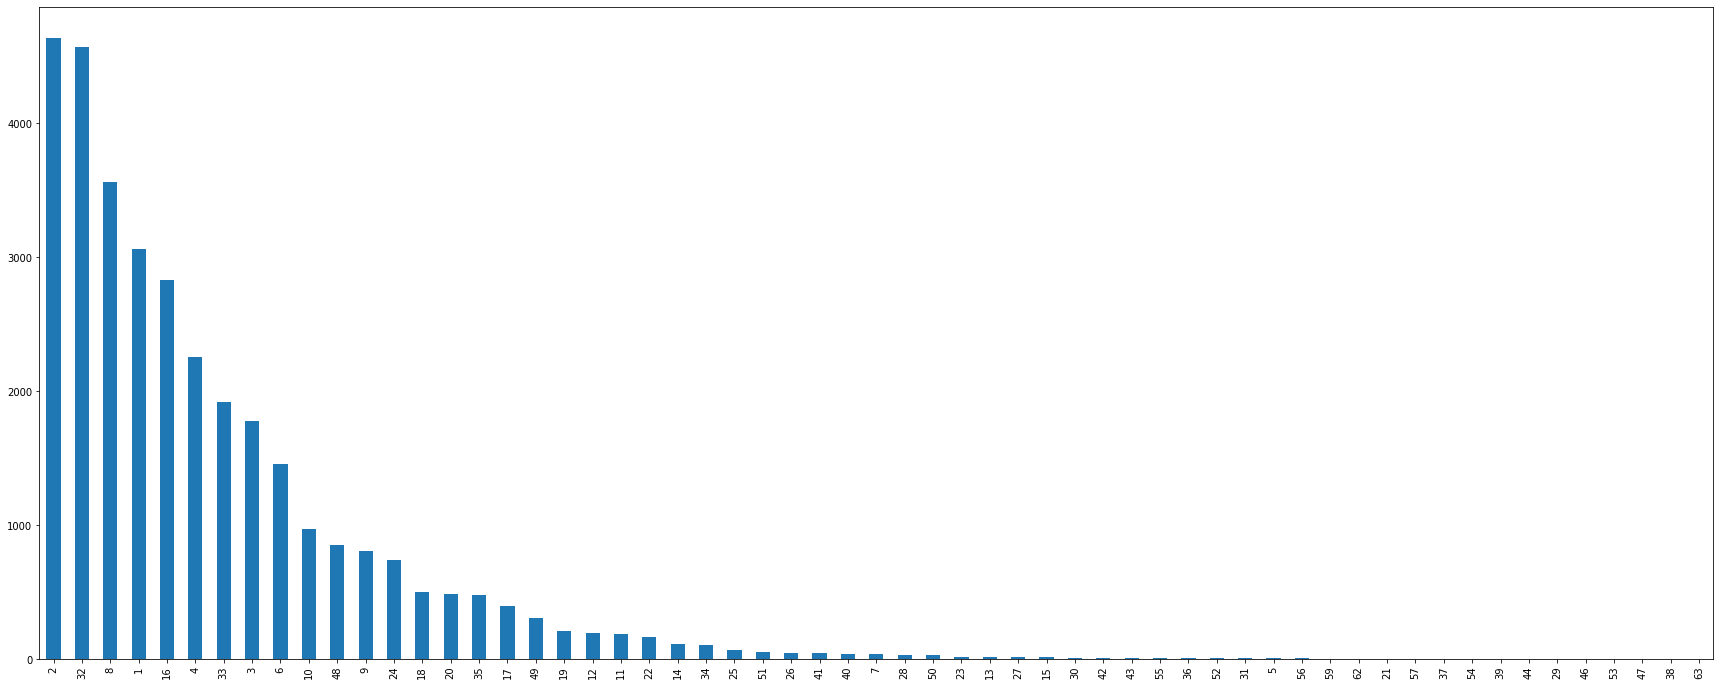

In [ ]:
(arxiv_data_filtered["powerlabel"].value_counts()).plot(kind='bar', figsize = (30, 12))

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(arxiv_data_filtered.summaries)
X_vector = vectorizer.transform(arxiv_data_filtered.summaries)

In [ ]:
y = np.array(arxiv_data_filtered['powerlabel']).astype('int')
y

array([ 3,  2,  6, ...,  1,  3, 11])

In [ ]:
#Random oversampling
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_vector,y)

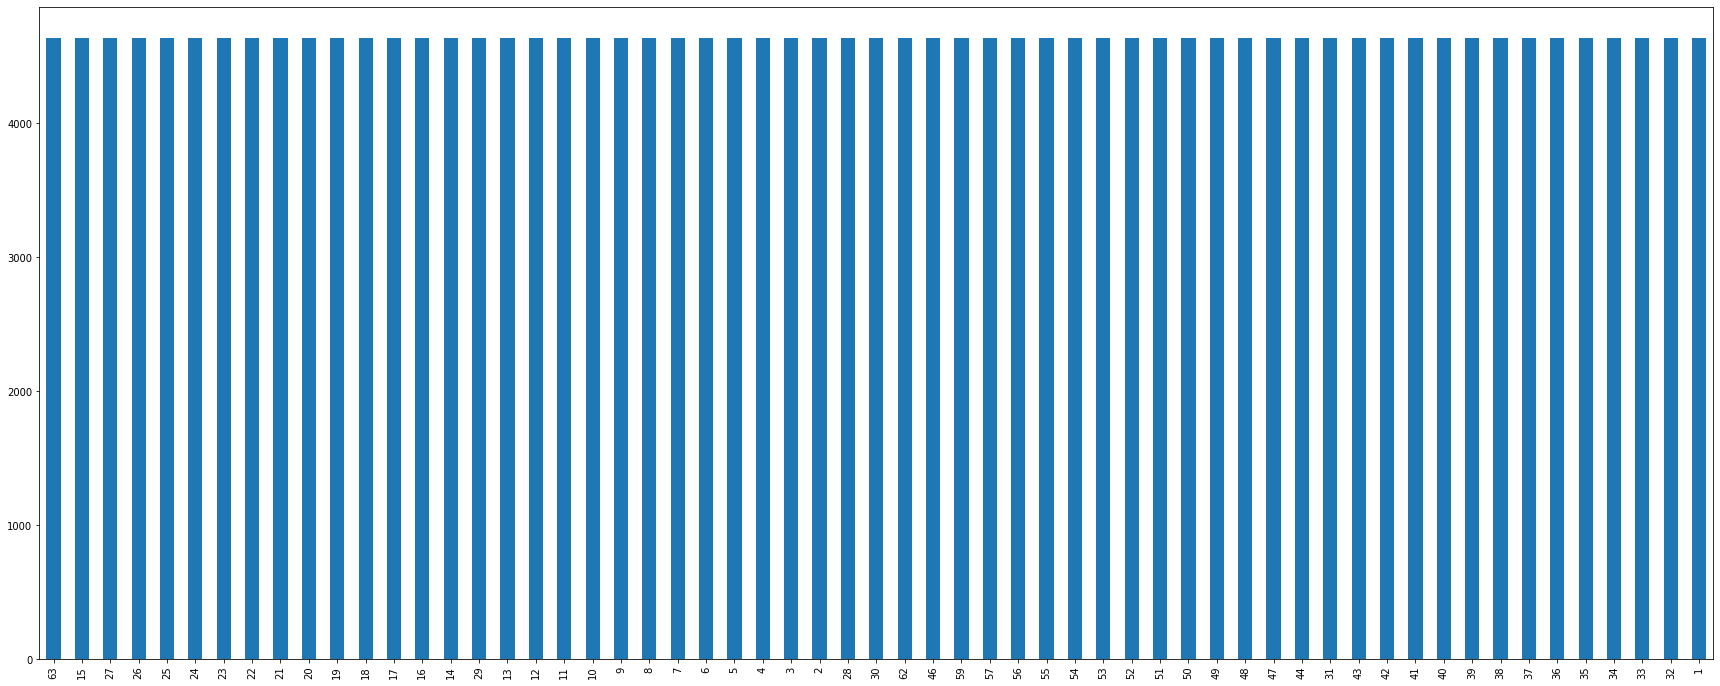

In [ ]:
#After oversampling
(pd.Series(y_resampled).value_counts()).plot(kind='bar', figsize = (30, 12))

In [ ]:
y_resampled_binary = (((y_resampled[:,None] & (1 << np.arange(len(all_terms_df))))) > 0).astype(int)

####Train the model (RAM OVERFLOW)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_binary, test_size = 0.2)

In [ ]:
# initialize label powerset multi-label classifier
# with a multinomial naive bayes base classifier
model = LabelPowerset(MultinomialNB())

model.fit(X_train, y_train)
# RAM OVERFLOW